In [8]:
import sys
sys.path.append("../")

In [11]:
import os
from roboflow import Roboflow
from config import ROBOFLOW_API_KEY

# Define the target folder path
target_folder = '../keypoints_detection/train/'

# Check if the folder already exists
if not os.path.exists(target_folder) or not os.listdir(target_folder):
    print(f"Dataset not found in {target_folder}, downloading...")

    # Initialize Roboflow and download the dataset
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
    project = rf.workspace("mihailo").project("football-field-detection-f07vi-apxzb")
    version = project.version(1)
    dataset = version.download("yolov8", location=target_folder)

    print(f"Dataset downloaded to {target_folder}")
else:
    print(f"Dataset already exists in {target_folder}, skipping download.")

Dataset already exists in ../keypoints_detection/train/, skipping download.


In [13]:
DATASET_PATH = '../keypoints_detection/train/football-field-detection-1'

IMAGES_DIR = f'{DATASET_PATH}/train/images/'
LABELS_DIR = f'{DATASET_PATH}/train/labels/'

# Plotting Data Example

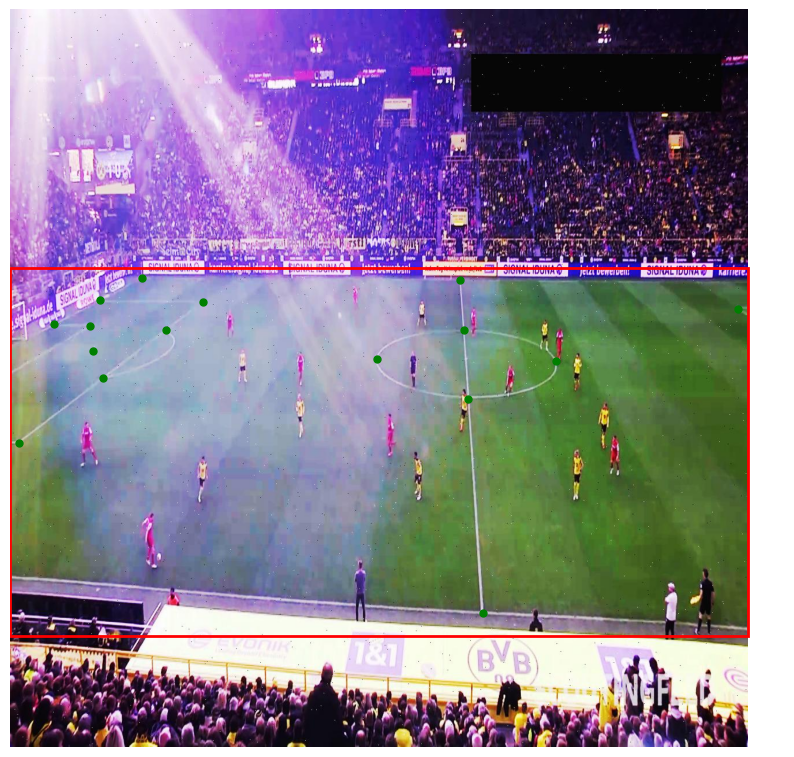

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Select a random image (ensure it has a corresponding label file)
image_file = '0a2d9b_2_3_png.rf.9b1fce0b61d3915ff3339f256628e615.jpg'
label_file = image_file.replace('.jpg', '.txt')

# Load the image
image_path = os.path.join(IMAGES_DIR, image_file)
image = Image.open(image_path)

# Load the label
label_path = os.path.join(LABELS_DIR, label_file)
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

# Image dimensions
image_width, image_height = image.size

# Plot bounding boxes and keypoints
for line in lines:
    # Each line corresponds to an object in YOLO format
    parts = line.strip().split()
    
    class_id = int(parts[0])
    
    # Extract bounding box information
    x_center = float(parts[1]) * image_width
    y_center = float(parts[2]) * image_height
    bbox_width = float(parts[3]) * image_width
    bbox_height = float(parts[4]) * image_height

    # Draw the bounding box
    top_left_x = x_center - bbox_width / 2
    top_left_y = y_center - bbox_height / 2
    rect = patches.Rectangle((top_left_x, top_left_y), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Plot keypoints (starting from index 5)
    keypoints = parts[5:]  # Each keypoint is stored as (x, y, v) triplets
    for i in range(0, len(keypoints), 3):
        x = float(keypoints[i]) * image_width
        y = float(keypoints[i + 1]) * image_height
        visibility = int(keypoints[i + 2])

        if visibility > 0:
            plt.plot(x, y, 'go', markersize=5) 

plt.axis('off')
plt.show()

# Calculating the Visibility of Each Keypoint

In [36]:
import os
import numpy as np
from tqdm import tqdm


def calculate_keypoint_visibility(dataset_path):
    visibility_counts = {}
    total_counts = {}

    # Iterate through all text files in the dataset directory
    for filename in tqdm(os.listdir(dataset_path)):
        if filename.endswith('.txt'):
            file_path = os.path.join(dataset_path, filename)
            
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    
                    # YOLO-Pose format: class x_center y_center width height keypoints...
                    # Keypoints are in the format: x1 y1 v1 x2 y2 v2 ...
                    if len(parts) > 5:  # Ensure there are keypoints
                        keypoints = parts[5:]
                        
                        for i in range(0, len(keypoints), 3):
                            keypoint_id = i // 3
                            visibility = float(keypoints[i+2])
                            
                            if keypoint_id not in visibility_counts:
                                visibility_counts[keypoint_id] = 0
                                total_counts[keypoint_id] = 0
                            
                            if visibility > 0:
                                visibility_counts[keypoint_id] += 1
                            total_counts[keypoint_id] += 1

    # Calculate visibility percentages
    visibility_percentages = {
        keypoint_id: (count / total_counts[keypoint_id]) * 100 
        for keypoint_id, count in visibility_counts.items()
    }

    return visibility_percentages

In [41]:
visibility_percentages = calculate_keypoint_visibility(LABELS_DIR)

print(visibility_percentages)

100%|██████████| 765/765 [00:00<00:00, 5615.42it/s]

{0: 50.98039215686274, 1: 45.09803921568628, 2: 40.0, 3: 34.11764705882353, 4: 23.52941176470588, 5: 7.8431372549019605, 6: 44.70588235294118, 7: 36.07843137254902, 8: 45.09803921568628, 9: 57.25490196078431, 10: 53.72549019607843, 11: 46.27450980392157, 12: 37.254901960784316, 13: 89.80392156862746, 14: 90.19607843137256, 15: 91.37254901960785, 16: 72.15686274509804, 17: 60.0, 18: 54.90196078431373, 19: 45.09803921568628, 20: 34.90196078431372, 21: 42.745098039215684, 22: 43.13725490196079, 23: 32.549019607843135, 24: 50.98039215686274, 25: 43.92156862745098, 26: 38.43137254901961, 27: 26.666666666666668, 28: 16.862745098039216, 29: 3.5294117647058822, 30: 81.96078431372548, 31: 80.7843137254902}


100%|██████████| 765/765 [00:00<00:00, 5019.42it/s]


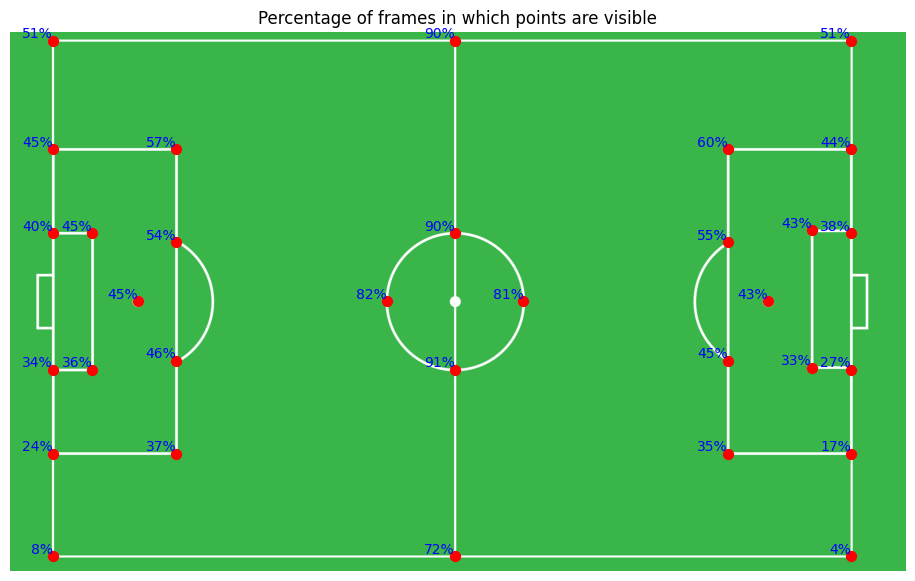

In [43]:
import cv2


visibility_percentages = calculate_keypoint_visibility(LABELS_DIR)

top_down_keypoints = np.array([
  [98, 19], [98, 268], [98, 460], [98, 773], [98, 964], [98, 1199], # 0-5
  [188, 460], [188, 773], # 6-7
  [292, 616], # 8
  [380, 268], [380, 481], [380, 752], [380, 964], # 9-12
  [1017, 19], [1017, 460], [1017, 773], [1017, 1199], # 13-16
  [1641, 268], [1641, 481], [1641, 752], [1641, 964], # 17-20
  [1733, 616], # 21
  [1833, 453], [1833, 767], # 22-23
  [1923, 19], [1923, 268], [1923, 460], [1923, 773], [1923, 964], [1923, 1199], # 24-29
  [861, 616], [1174, 616] # 30-31
])

template = cv2.imread('data/2d_football_pitch.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,7))
plt.title("Percentage of frames in which points are visible")
plt.axis(False)
plt.imshow(template)

for i, percentage in visibility_percentages.items():
  plt.scatter(top_down_keypoints[i][0], top_down_keypoints[i][1], s=50, c='red', marker='o')
  plt.text(top_down_keypoints[i][0], top_down_keypoints[i][1], f'{round(percentage)}%', fontsize=10, color='blue', ha='right', va='bottom')

plt.savefig('../output_videos/percentage_of_visible_frames_for_each_point.png')
plt.show()

# Plotting The Field Projection

In [44]:
def create_radial_gradients(template_shape, keypoints, scale_factor=.01):
    """
    Create radial gradients centered at the given keypoints.

    Arguments:
        template_shape: tuple (height, width), shape of the template image
        keypoints: np.array of shape (N, 2), coordinates of keypoints
        scale_factor: float, scaling factor for gradient strength

    Returns:
        radial_gradients: np.array of shape (height, width), the combined radial gradients
    """

    height, width = template_shape
    radial_gradients = np.zeros((height, width), dtype=np.float32)
    
    for keypoint in keypoints:
        kp_x, kp_y = keypoint
        
        # Generate x and y coordinates centered at the keypoint
        y = np.linspace(0, height - 1, height)
        x = np.linspace(0, width - 1, width)
        x_coord, y_coord = np.meshgrid(x, y)
        
        # Calculate the distance from the keypoint
        distances = np.sqrt((x_coord - kp_x) ** 2 + (y_coord - kp_y) ** 2)
        
        # Apply the radial gradient with scaling factor
        radial_gradient = np.exp(-distances * scale_factor)
        
        # Add the radial gradient to the overall radial gradients
        radial_gradients = np.maximum(radial_gradients, radial_gradient)
    
    # Normalize the combined radial gradients
    radial_gradients = np.clip(radial_gradients, 0, 1)
    
    return radial_gradients

def rgb_template_to_radial_gradient_template(rgb_template, keypoints, scale_factor=.01):
    """
    Convert an RGB template image to a radial gradient template with gradients centered at keypoints.

    Arguments:
        rgb_template: np.array of shape (H, W, 3), RGB template image
        keypoints: np.array of shape (N, 2), coordinates of keypoints
        scale_factor: float, scaling factor for gradient strength

    Returns:
        radial_gradient_template: np.array of shape (H, W, 3), the radial gradient template
    """
    
    # Convert to grayscale by averaging the RGB channels
    rgb_template = np.mean(rgb_template, axis=2)
    
    # Create radial gradients for the keypoints
    radial_gradients = create_radial_gradients(rgb_template.shape, keypoints, scale_factor)
    
    # Stack the grayscale template with the radial gradients
    radial_gradient_template = np.stack((rgb_template, radial_gradients, radial_gradients), axis=2)
    
    return radial_gradient_template

In [45]:
def resize_keypoints(keypoints, original_width, original_height, new_width, new_height):
    """
    Resize keypoints from the original image dimensions to new dimensions.

    Arguments:
        keypoints: np.array of shape (N, 2), coordinates of keypoints in the original image
        original_width: int, width of the original image
        original_height: int, height of the original image
        new_width: int, width of the new image dimensions
        new_height: int, height of the new image dimensions

    Returns:
        resized_keypoints: np.array of shape (N, 2), coordinates of keypoints resized to the new image dimensions
    """
    # Calculate the scaling factors for width and height
    scale_x = new_width / original_width
    scale_y = new_height / original_height
    
    # Apply the scaling factors to the keypoints
    resized_keypoints = keypoints * np.array([scale_x, scale_y])
    
    return resized_keypoints

In [46]:
def visualize(image, label=""):
    """
    Plot an image with label

    Arguments:
        image: image to plot,
        label: plot title
    Returns:

    """
    plt.figure(figsize=(8, 5))
    plt.title(label)
    plt.axis(False)
    plt.imshow(image)
    plt.show()


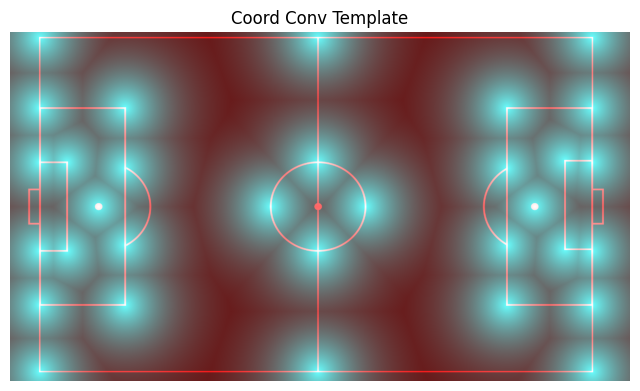

In [47]:
# Normalize and resize field image
template = cv2.imread('data/2d_football_pitch.png')
height, width, _ = template.shape
top_down_keypoints_resized = resize_keypoints(top_down_keypoints, width, height, 1280, 720)
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.

# Apply Coord Conv to Template image
radial_gradient_template = rgb_template_to_radial_gradient_template(template, top_down_keypoints_resized, scale_factor=.01)

visualize(radial_gradient_template, "Coord Conv Template")

In [87]:
def compute_homography(src_points, dst_points):
    """
    Compute a single homography matrix between source and destination points.

    Arguments:
        src_points: numpy array of shape (n, 2) - source points coordinates
        dst_points: numpy array of shape (n, 2) - destination points coordinates

    Returns:
        homography: numpy array of shape (3, 3) - the homography matrix
    """
    # Compute the homography matrix using RANSAC
    src_points = np.array(src_points, dtype=np.float32)
    dst_points = np.array(dst_points, dtype=np.float32)
    h, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC)
    
    return h.astype(np.float32)

In [49]:
import cv2
import numpy as np

def warp_image(image, H, output_shape=None):
    """
    Warp an image using a homography matrix.

    Arguments:
        image: numpy array of shape (height, width, n_channels) - the image to be warped
        H: numpy array of shape (3, 3) - the homography matrix to apply
        output_shape (optional): tuple of (height, width) - output shape of the warped image

    Returns:
        numpy array of shape (height2, width2, n_channels) - the warped image
    """
    if output_shape is None:
        output_shape = image.shape[:2]

    return cv2.warpPerspective(image, H, dsize=output_shape)


In [50]:
def merge_template(image, warped_template):
    """
    Merge an image with a warped template by averaging overlapping regions.

    Arguments:
        image: numpy array of shape (height, width, n_channels) - the base image
        warped_template: numpy array of shape (height, width, n_channels) - the warped template to overlay

    Returns:
        numpy array of shape (height, width, n_channels) - the merged image
    """
    # Create a mask where the warped template has non-zero values
    mask = warped_template[:, :, 0] > 0.0
    
    # Average the overlapping regions
    merged_image = np.copy(image)
    merged_image[mask] = (image[mask].astype("float32") + warped_template[mask].astype("float32")) / 2
    
    return merged_image

In [80]:
def load_image(image_path):
    """
    Load an image from the given path.
    """
    return cv2.imread(image_path)

def load_keypoints(keypoints_path):
    """
    Load keypoints from the given file path.
    """
    keypoints = []
    with open(keypoints_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            current_keypoints = parts[5:]  # Each keypoint is stored as (x, y, v) triplets
            for i in range(0, len(current_keypoints), 3):
                x = float(current_keypoints[i]) * image_width
                y = float(current_keypoints[i + 1]) * image_height
                visibility = float(current_keypoints[i + 2])

                keypoints.append([x, y, visibility])
    return np.array(keypoints)

In [82]:
def homography_visualization(image, keypoints, template, top_down_keypoints, width, height):
    """
    Apply homography to warp a template image and visualize it over a base image.

    Arguments:
        image: numpy array of shape (height, width, n_channels) - the base image
        keypoints: numpy array of shape (n, 3) - keypoints in the base image, with visibility flag
        template: numpy array of shape (height, width, n_channels) - the template image to warp
        top_down_keypoints: numpy array of shape (n, 2) - keypoints in the template image

    Returns:
        None
    """
    # Resize top-down keypoints to match the base image dimensions
    resized_keypoints = resize_keypoints(top_down_keypoints, width, height, 1280, 1280)
    
    # Create source and destination points for homography
    src_points = []
    dst_points = []
    for i, kp in enumerate(keypoints):
        if kp[2] != 0:  # Check if the keypoint is visible
            dst_points.append(kp[:2])
            src_points.append(resized_keypoints[i])
    
    src_points = np.array(src_points)
    dst_points = np.array(dst_points)
    
    # Compute homography matrix
    homography = compute_homography(src_points, dst_points)
    
    # Warp the template image using the homography matrix
    warped_template = warp_image(cv2.resize(template, (1280, 1280)), homography, output_shape=(1280, 1280))
    
    # Merge the warped template with the base image
    merged_image = merge_template(image / 255.0, cv2.resize(warped_template, (1280, 1280)))
    
    # Visualize the result
    visualize(merged_image)

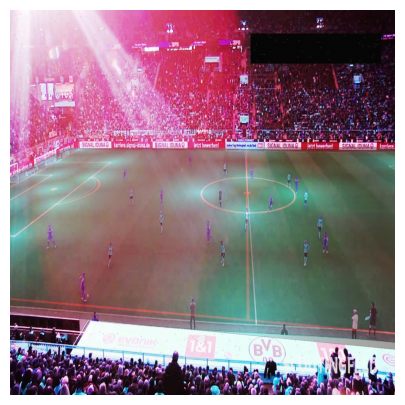

In [88]:
image_file = '0a2d9b_2_3_png.rf.9b1fce0b61d3915ff3339f256628e615.jpg'
label_file = image_file.replace('.jpg', '.txt')

image = load_image(os.path.join(IMAGES_DIR, image_file))
keypoints = load_keypoints(os.path.join(LABELS_DIR, label_file))

homography_visualization(image, keypoints, radial_gradient_template, top_down_keypoints, width, height)

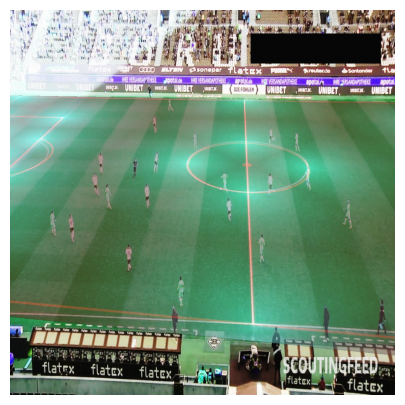

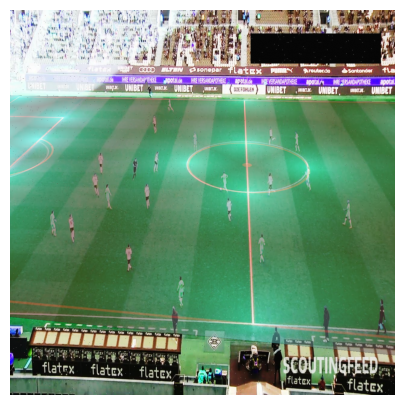

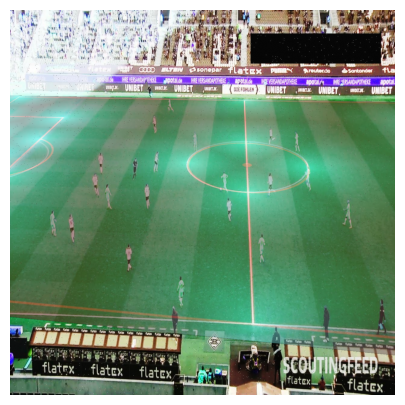

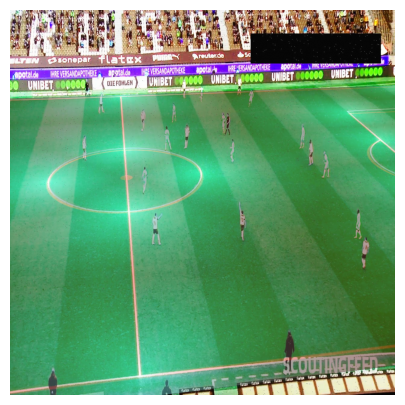

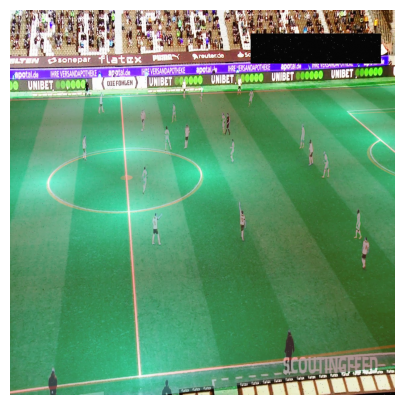

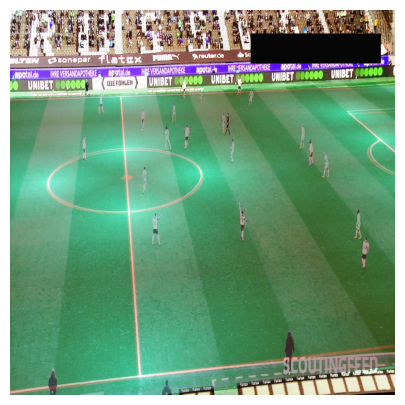

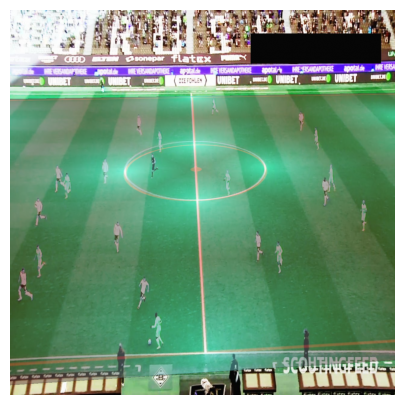

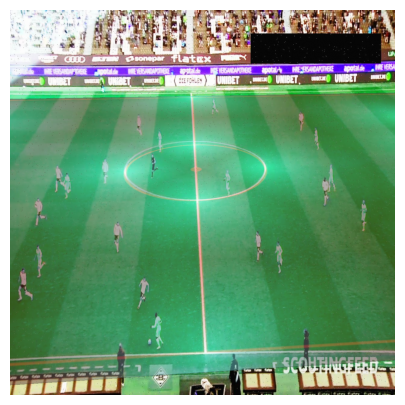

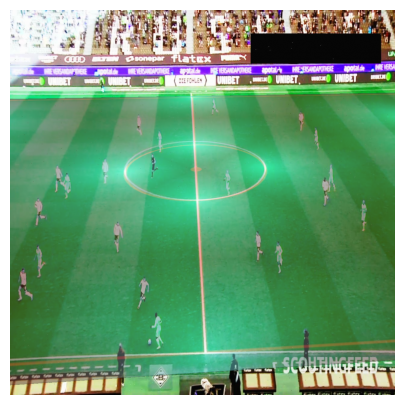

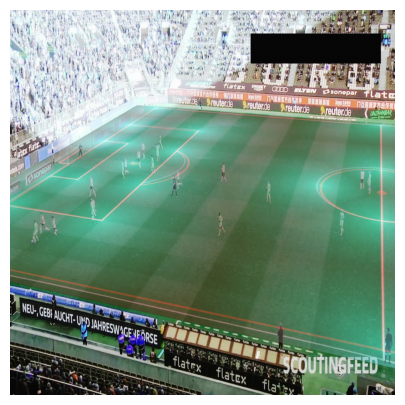

In [89]:
# Number of images to plot
num_images = 10

# Get list of image files
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith('.jpg')][:num_images]

for image_file in image_files:
    label_file = image_file.replace('.jpg', '.txt')
    
    image_path = os.path.join(IMAGES_DIR, image_file)
    label_path = os.path.join(LABELS_DIR, label_file)
    
    if os.path.exists(image_path) and os.path.exists(label_path):
        image = load_image(image_path)
        keypoints = load_keypoints(label_path)
        
        homography_visualization(image, keypoints, radial_gradient_template, top_down_keypoints, width, height)
    else:
        print(f"Missing file: {image_path} or {label_path}")